Streaming output truncated to the last 5000 lines.
  inflating: folk-art-dataset-main/Rajasthani Miniature Painting (Rajasthan)/282.jpg  
  inflating: folk-art-dataset-main/Rajasthani Miniature Painting (Rajasthan)/283.jpg  
  inflating: folk-art-dataset-main/Rajasthani Miniature Painting (Rajasthan)/284.jpg  
  inflating: folk-art-dataset-main/Rajasthani Miniature Painting (Rajasthan)/285.jpg  
  inflating: folk-art-dataset-main/Rajasthani Miniature Painting (Rajasthan)/286.jpg  
  inflating: folk-art-dataset-main/Rajasthani Miniature Painting (Rajasthan)/287.jpg  
  inflating: folk-art-dataset-main/Rajasthani Miniature Painting (Rajasthan)/288.jpg  
  inflating: folk-art-dataset-main/Rajasthani Miniature Painting (Rajasthan)/289.jpg  
  inflating: folk-art-dataset-main/Rajasthani Miniature Painting (Rajasthan)/29.jpg  
  inflating: folk-art-dataset-main/Rajasthani Miniature Painting (Rajasthan)/290.jpg  
  inflating: folk-art-dataset-main/Rajasthani Miniature Painting (Rajasthan)/291

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


87910968/87910968 [==============================] - 0s 0us/step
Epoch 1/50
808/808 [==============================] - 87s 103ms/step - loss: 3.1676 - accuracy: 0.0979 - val_loss: 2.7471 - val_accuracy: 0.2316
Epoch 2/50
808/808 [==============================] - 79s 97ms/step - loss: 2.9251 - accuracy: 0.1374 - val_loss: 2.6027 - val_accuracy: 0.2773
Epoch 3/50
808/808 [==============================] - 79s 98ms/step - loss: 2.8242 - accuracy: 0.1656 - val_loss: 2.4745 - val_accuracy: 0.3125
Epoch 4/50
808/808 [==============================] - 79s 98ms/step - loss: 2.7695 - accuracy: 0.1719 - val_loss: 2.4235 - val_accuracy: 0.3344
Epoch 5/50
808/808 [==============================] - 79s 97ms/step - loss: 2.7325 - accuracy: 0.1802 - val_loss: 2.4469 - val_accuracy: 0.3212
Epoch 6/50
808/808 [==============================] - 79s 97ms/step - loss: 2.7059 - accuracy: 0.1824 - val_loss: 2.3503 - val_accuracy: 0.3458
Epoch 7/50
808/808 [==============================] - 79s 97ms/step - 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


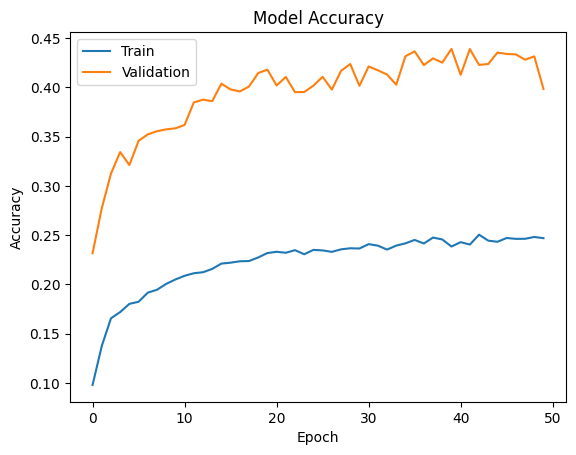

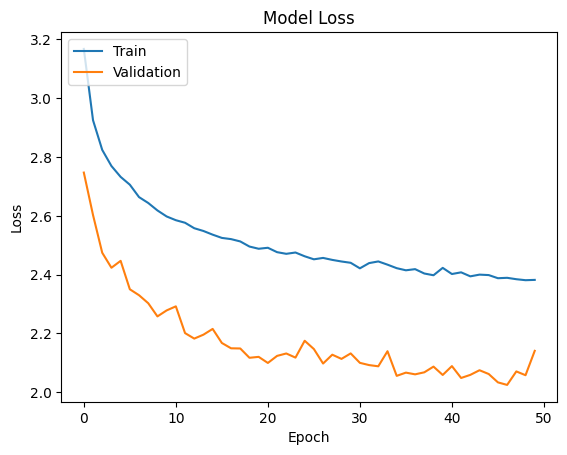

In [ ]:
# Step 1: Import Libraries
import os
import numpy as np
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

# Step 2: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Step 3: Download and Unzip Dataset (Uncomment if not done previously)
!pip install -q kaggle
# Upload your kaggle.json and run the below commands
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d abhaysharma38/indian-folk-art-gallery-high-resolution-images
!unzip indian-folk-art-gallery-high-resolution-images.zip

# Step 4: Load and Preprocess Images
image_dir = '/content/folk-art-dataset-main/'  # Change if necessary
labels = os.listdir(image_dir)
IMG_SIZE = 128  # Image dimensions
images = []
image_labels = []

def load_images(image_dir, labels):
    for label in labels:
        label_dir = os.path.join(image_dir, label)
        if os.path.isdir(label_dir):
            for img_file in os.listdir(label_dir):
                img_path = os.path.join(label_dir, img_file)
                file_extension = img_file.split('.')[-1].lower()  # Get file extension
                if file_extension not in ['jpg', 'jpeg', 'png', 'gif']:  # Supported formats
                    print(f"Unsupported format for image: {img_path}")
                    continue

                try:
                    # Use PIL to open images
                    image = Image.open(img_path)
                    image = image.convert('RGB')  # Convert to RGB
                    image = image.resize((IMG_SIZE, IMG_SIZE))  # Resize to IMG_SIZE
                    image = np.array(image)  # Convert to numpy array

                    # Ensure the image shape is as expected
                    if image.shape == (IMG_SIZE, IMG_SIZE, 3):
                        images.append(image)
                        image_labels.append(label)
                    else:
                        print(f"Image shape mismatch for {img_path}: {image.shape}")
                except Exception as e:
                    print(f"Error loading image: {img_path} - {e}")

load_images(image_dir, labels)

# Convert images to numpy array
images = np.array(images, dtype='float32')
# Normalize pixel values to [0, 1]
images /= 255.0

# Map labels to numerical values
label_to_num = {label: idx for idx, label in enumerate(np.unique(image_labels))}
numerical_labels = np.array([label_to_num[label] for label in image_labels])
y_categorical = to_categorical(numerical_labels, num_classes=len(label_to_num))

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, y_categorical, test_size=0.2, random_state=42)

# Step 5: Load InceptionV3 Model and Add Custom Layers
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Define input size and number of labels
num_classes = len(label_to_num)  # Number of classes in your dataset

# Load the pre-trained InceptionV3 model (without the top layer)
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False  # Freeze the base model layers

# Add custom layers on top of InceptionV3
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global Average Pooling to reduce dimensionality
x = Dense(128, activation='relu')(x)  # Dense layer with ReLU activation
x = Dropout(0.5)(x)  # Dropout for regularization
output = Dense(num_classes, activation='softmax')(x)  # Output layer for classification

# Create the complete model
inception_model = Model(inputs=base_model.input, outputs=output)

# Compile the model
inception_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Step 6: Train the Model
inception_history = inception_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32)

# Save the model
inception_model.save('/content/drive/MyDrive/inception_folk_art_model50.h5')

# Step 7: Visualize Training Results
def plot_accuracy_and_loss(history):
    # Plot history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

# Call the plot function to visualize training progress
plot_accuracy_and_loss(inception_history)


Please upload an image for testing:


Saving 34.jpg to 34.jpg


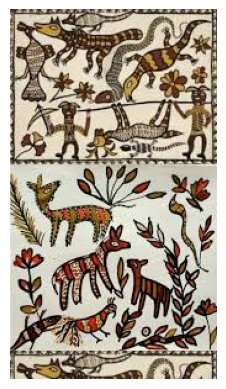

1/1 [==============================] - 1s 1s/step
Predicted Label: Bhil Painting (Madhya Pradesh)
Confidence: 0.37


In [ ]:
# Step 1: Import Libraries
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from google.colab import files
from PIL import Image
import matplotlib.pyplot as plt

# Step 2: Define Labels
class_labels = [
    'Aipan Art (Uttarakhand)', 'Assamese Miniature Painting (Assam)', 'Basholi Painting (Jammu and Kashmir)',
    'Bhil Painting (Madhya Pradesh)', 'Chamba Rumal (Himachal Pradesh)', 'Cheriyal Scroll Painting (Telangana)',
    'Dokra Art (West Bengal)', 'Gond Painting (Madhya Pradesh)', 'Kalamkari Painting (Andhra Pradesh and Telangana)',
    'Kalighat Painting (West Bengal)', 'Kangra Painting (Himachal Pradesh)', 'Kerala Mural Painting (Kerala)',
    'Kondapalli Bommallu (Andhra Pradesh)', 'Kutch Lippan Art (Gujarat)', 'Leather Puppet Art (Andhra Pradesh)',
    'Madhubani Painting (Bihar)', 'Mandala Art', 'Mandana Art (Rajasthan)', 'Mata Ni Pachedi (Gujarat)',
    'Meenakari Painting (Rajasthan)', 'Mughal Paintings', 'Mysore Ganjifa Art (Karnataka)',
    'Pattachitra Painting (Odisha and Bengal)', 'Patua Painting (West Bengal)', 'Pichwai Painting (Rajasthan)',
    'Rajasthani Miniature Painting (Rajasthan)', 'Rogan Art from Kutch (Gujarat)', 'Sohrai Art (Jharkhand)',
    'Tikuli Art (Bihar)', 'Warli Folk Painting (Maharashtra)'
]

# Step 3: Load Trained Model
model_path = '/content/drive/MyDrive/inception_folk_art_model50.h5'  # Replace with your model path
model = load_model(model_path)

# Image size used for training the model
IMG_SIZE = 128

# Step 4: Define Image Preprocessing Function
def preprocess_image(image_path):
    """
    Preprocess the uploaded image for prediction.
    """
    try:
        image = Image.open(image_path)
        image = image.convert('RGB')  # Convert to RGB if not already
        image = image.resize((IMG_SIZE, IMG_SIZE))  # Resize to model's input size
        image = img_to_array(image)  # Convert to numpy array
        image = image / 255.0  # Normalize the image
        image = np.expand_dims(image, axis=0)  # Add batch dimension
        return image
    except Exception as e:
        print(f"Error processing image: {e}")
        return None

# Step 5: Define Prediction Function
def predict_image(image_array):
    """
    Predict the class of the input image.
    """
    predictions = model.predict(image_array)
    predicted_class = np.argmax(predictions)  # Get the index of the highest confidence
    confidence = np.max(predictions)  # Get the confidence of the prediction
    return class_labels[predicted_class], confidence

# Step 6: Upload Image and Predict
print("Please upload an image for testing:")
uploaded = files.upload()

# Step 7: Process and Display Results
for filename in uploaded.keys():
    # Display the uploaded image
    img = Image.open(filename)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    # Preprocess the image
    image_array = preprocess_image(filename)
    if image_array is not None:
        # Predict the image
        predicted_label, confidence = predict_image(image_array)
        print(f"Predicted Label: {predicted_label}")
        print(f"Confidence: {confidence:.2f}")
    else:
        print("Failed to preprocess the image.")
